In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pycocotools
from pycocotools import mask
import json
import numpy as np
import pycocotools.mask as mask_util
from skimage import measure
import os
from tqdm import tqdm
from tqdm.notebook import tqdm
import cv2
import random
from itertools import groupby
import itertools
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from glob import glob
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *

In [7]:
df1 = pd.read_csv('/content/drive/MyDrive/Kaggle/uw-madison-gi-tract-image-segmentation/train.csv')
print(df1.shape)
df1.sample(5)

(115488, 3)


,id,class,segmentation
56742,case32_day20_slice_0083,large_bowel,18546 2 18810 8 19075 10 19340 13 19606 14 198...
110382,case2_day1_slice_0027,large_bowel,NaN
34898,case113_day22_slice_0001,stomach,NaN
44439,case154_day13_slice_0014,large_bowel,NaN
2485,case77_day18_slice_0109,small_bowel,26509 1 26730 4 26772 5 26995 6 27037 7 27260 ...


In [6]:
# Metadata
def preprocessing(df, subset="train"):
    df["case"] = df["id"].apply(lambda x: int(x.split("_")[0].replace("case", "")))
    df["day"] = df["id"].apply(lambda x: int(x.split("_")[1].replace("day", "")))
    df["slice"] = df["id"].apply(lambda x: x.split("_")[3])
    
    if (subset=="train") or (DEBUG):
        # DIR="../input/uw-madison-gi-tract-image-segmentation/train"
        DIR="/content/drive/MyDrive/Kaggle/uw-madison-gi-tract-image-segmentation/train"
    else:
        # DIR="../input/uw-madison-gi-tract-image-segmentation/test"
        DIR="/content/drive/MyDrive/Kaggle/uw-madison-gi-tract-image-segmentation/test"
    
    all_images = glob(os.path.join(DIR, "**", "*.png"), recursive=True)
    x = all_images[0].rsplit("/", 4)[0] 

    path_partial_list = []
    for i in range(0, df.shape[0]):
        path_partial_list.append(os.path.join(x,
                              "case"+str(df["case"].values[i]),
                              "case"+str(df["case"].values[i])+"_"+ "day"+str(df["day"].values[i]),
                              "scans",
                              "slice_"+str(df["slice"].values[i])))
    df["path_partial"] = path_partial_list
    #--------------------------------------------------------------------------
    path_partial_list = []
    for i in range(0, len(all_images)):
        path_partial_list.append(str(all_images[i].rsplit("_",4)[0]))

    tmp_df = pd.DataFrame()
    tmp_df['path_partial'] = path_partial_list
    tmp_df['path'] = all_images

    #--------------------------------------------------------------------------
    df = df.merge(tmp_df, on="path_partial").drop(columns=["path_partial"])
    #print(df['id'])
    #--------------------------------------------------------------------------
    df["filename"] = df["path"].apply(lambda x: x.split('/')[-1])
    df['unique_filename'] = df.apply(lambda row: str(row.case) + '_' + str(row.day)+'_'+str(row.filename), axis=1)

    df["width"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
    df["height"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))
    #--------------------------------------------------------------------------
    df["px_spacing_h"] = df["path"].apply(lambda x: float(x[:-4].rsplit("_",4)[3]))
    df["px_spacing_w"] = df["path"].apply(lambda x: float(x[:-4].rsplit("_",4)[4][:4]))
    #--------------------------------------------------------------------------
    del x, path_partial_list, tmp_df
    #--------------------------------------------------------------------------
    # new_col_order = ["id", "path", "segmentation"
    #                  "height", "width", "px_spacing_h", 
    #                  "px_spacing_w",  "case",  "day", "slice",]

    # if subset!="train": 
    #   new_col_order.insert(1, "class")

    # new_col_order = [_c for _c in new_col_order if _c in df.columns]
    # df = df[new_col_order]
    return df

In [10]:
df1 = preprocessing(df1, subset="train")
df1.head()

,id,class,segmentation,case,day,slice,path,filename,unique_filename,width,height,px_spacing_h,px_spacing_w
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,/content/drive/MyDrive/Kaggle/uw-madison-gi-tr...,slice_0001_266_266_1.50_1.50.png,123_20_slice_0001_266_266_1.50_1.50.png,266,266,1.5,1.5
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,/content/drive/MyDrive/Kaggle/uw-madison-gi-tr...,slice_0001_266_266_1.50_1.50.png,123_20_slice_0001_266_266_1.50_1.50.png,266,266,1.5,1.5
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,/content/drive/MyDrive/Kaggle/uw-madison-gi-tr...,slice_0001_266_266_1.50_1.50.png,123_20_slice_0001_266_266_1.50_1.50.png,266,266,1.5,1.5
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,/content/drive/MyDrive/Kaggle/uw-madison-gi-tr...,slice_0002_266_266_1.50_1.50.png,123_20_slice_0002_266_266_1.50_1.50.png,266,266,1.5,1.5
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,/content/drive/MyDrive/Kaggle/uw-madison-gi-tr...,slice_0002_266_266_1.50_1.50.png,123_20_slice_0002_266_266_1.50_1.50.png,266,266,1.5,1.5


In [11]:
df1.columns


Index(['id', 'class', 'segmentation', 'case', 'day', 'slice', 'path',
       'filename', 'unique_filename', 'width', 'height', 'px_spacing_h',
       'px_spacing_w'],
      dtype='object')

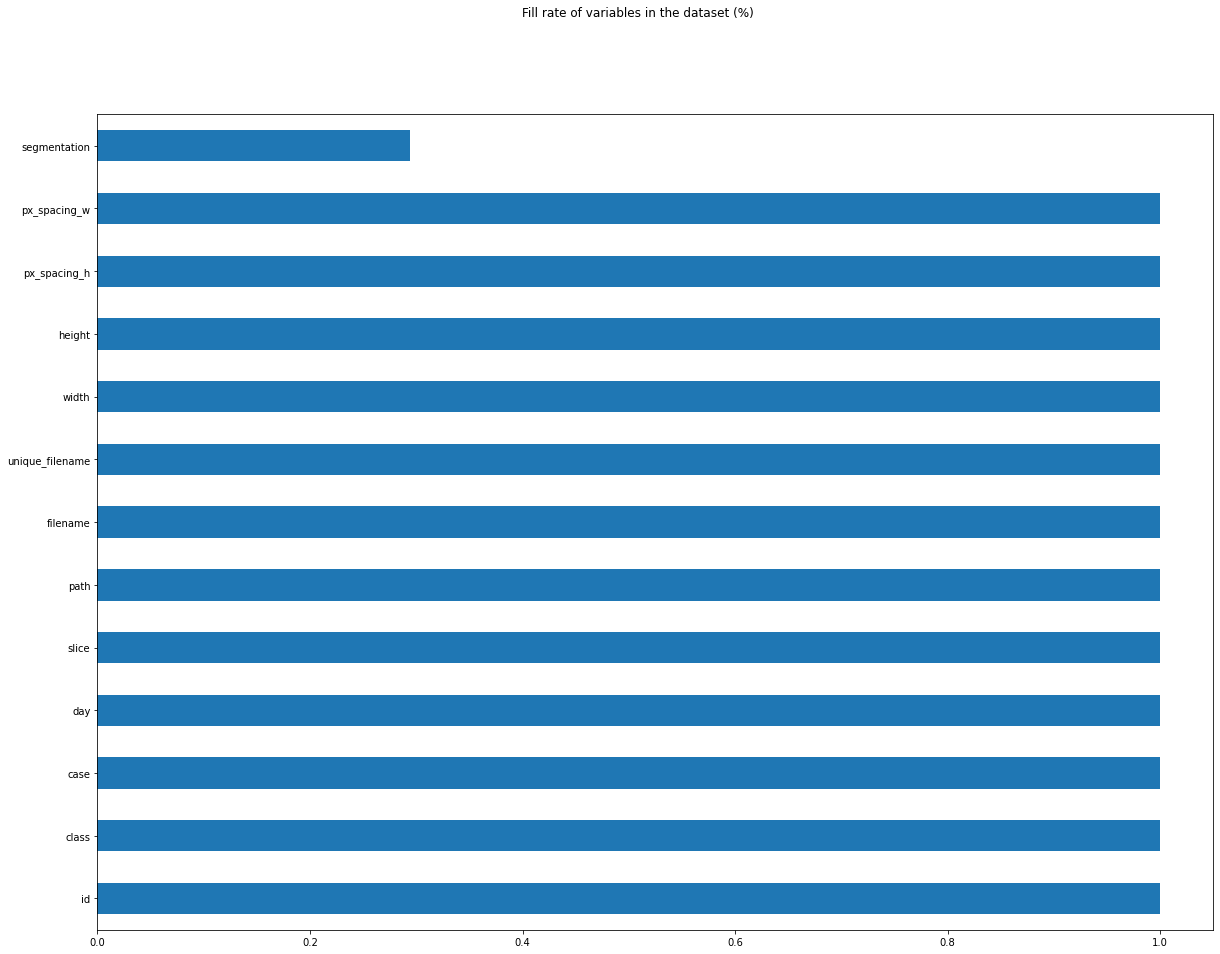

In [12]:
me = (df1.notna().mean(axis=0)).sort_values(ascending=False)
plt.suptitle("Fill rate of variables in the dataset (%)")
me.plot(kind='barh', figsize=(20, 15))

In [13]:
df1[df1['segmentation'].isnull()].shape


(81579, 13)

In [14]:
df1[df1['segmentation'].notnull()].shape


(33921, 13)

In [15]:
# Remove misslabeled training data
df1 = df1[(df1['case'] != 7) | (df1['case'] != 0)].reset_index(drop=True)
df1 = df1[(df1['case'] != 81) | (df1['case'] != 30)].reset_index(drop=True)


In [16]:
df_with_mask = df1[df1['segmentation'].notnull()].copy()
df_with_mask["segmentation"] = df1["segmentation"].astype("str")
df_with_mask = df_with_mask.reset_index(drop=True)
df_with_mask.head()

,id,class,segmentation,case,day,slice,path,filename,unique_filename,width,height,px_spacing_h,px_spacing_w
0,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...,123,20,0065,/content/drive/MyDrive/Kaggle/uw-madison-gi-tr...,slice_0065_266_266_1.50_1.50.png,123_20_slice_0065_266_266_1.50_1.50.png,266,266,1.5,1.5
1,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...,123,20,0066,/content/drive/MyDrive/Kaggle/uw-madison-gi-tr...,slice_0066_266_266_1.50_1.50.png,123_20_slice_0066_266_266_1.50_1.50.png,266,266,1.5,1.5
2,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...,123,20,0067,/content/drive/MyDrive/Kaggle/uw-madison-gi-tr...,slice_0067_266_266_1.50_1.50.png,123_20_slice_0067_266_266_1.50_1.50.png,266,266,1.5,1.5
3,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...,123,20,0068,/content/drive/MyDrive/Kaggle/uw-madison-gi-tr...,slice_0068_266_266_1.50_1.50.png,123_20_slice_0068_266_266_1.50_1.50.png,266,266,1.5,1.5
4,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...,123,20,0069,/content/drive/MyDrive/Kaggle/uw-madison-gi-tr...,slice_0069_266_266_1.50_1.50.png,123_20_slice_0069_266_266_1.50_1.50.png,266,266,1.5,1.5


In [17]:
final_df = pd.DataFrame({'id' : df_with_mask['id'][::3]})

# final_df['lb_seg'] =df1[df1["class"]=="large_bowel"]["segmentation"]
# final_df['sb_seg'] = df1[df1["class"]=="small_bowel"]["segmentation"]
# final_df['st_seg']  = df1[df1["class"]=="stomach"]["segmentation"]
final_df['large_bowel'] = df_with_mask['segmentation'][::3].values
final_df['small_bowel'] = df_with_mask['segmentation'][1::3].values
final_df['stomach'] = df_with_mask['segmentation'][2::3].values

final_df['case'] =  df_with_mask['case'][::3].values
final_df['day'] =  df_with_mask['day'][::3].values
final_df['slice'] =  df_with_mask['slice'][::3].values
final_df['path'] =  df_with_mask['path'][::3].values
final_df['width'] =  df_with_mask['width'][::3].values
final_df['height'] =  df_with_mask['height'][::3].values
final_df['px_spacing_h'] =  df_with_mask['px_spacing_h'][::3].values
final_df['px_spacing_w'] =  df_with_mask['px_spacing_w'][::3].values
# final_df = final_df.drop_duplicates(subset=["id"])

final_df.reset_index(inplace=True,drop=True)
final_df.fillna('',inplace=True)
final_df['count'] = np.sum(final_df.iloc[:,1:4]!='',axis=1).values
train_df  = final_df.copy()
final_df.sample(2)

,id,large_bowel,small_bowel,stomach,case,day,slice,path,width,height,px_spacing_h,px_spacing_w,count
11037,case2_day3_slice_0109,25083 7 25347 11 25612 13 25877 14 26142 16 26...,22721 8 22985 14 23249 19 23511 31 23772 37 24...,24819 3 25082 9 25347 12 25611 14 25877 15 261...,2,3,0109,/content/drive/MyDrive/Kaggle/uw-madison-gi-tr...,266,266,1.5,1.5,3
714,case139_day16_slice_0086,25388 9 25652 13 25917 15 26183 16 26212 4 264...,28006 6 28269 10 28294 6 28534 12 28558 9 2879...,30993 3 31257 6 31522 9 31788 18 32054 19 3230...,139,16,0086,/content/drive/MyDrive/Kaggle/uw-madison-gi-tr...,266,266,1.5,1.5,3


In [18]:
df_with_mask.to_csv('/content/drive/MyDrive/Kaggle/train_with_mask.csv', index= False)

In [19]:
train = pd.read_csv('/content/drive/MyDrive/Kaggle/train_with_mask.csv')
train.head()

,id,class,segmentation,case,day,slice,path,filename,unique_filename,width,height,px_spacing_h,px_spacing_w
0,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...,123,20,65,/content/drive/MyDrive/Kaggle/uw-madison-gi-tr...,slice_0065_266_266_1.50_1.50.png,123_20_slice_0065_266_266_1.50_1.50.png,266,266,1.5,1.5
1,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...,123,20,66,/content/drive/MyDrive/Kaggle/uw-madison-gi-tr...,slice_0066_266_266_1.50_1.50.png,123_20_slice_0066_266_266_1.50_1.50.png,266,266,1.5,1.5
2,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...,123,20,67,/content/drive/MyDrive/Kaggle/uw-madison-gi-tr...,slice_0067_266_266_1.50_1.50.png,123_20_slice_0067_266_266_1.50_1.50.png,266,266,1.5,1.5
3,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...,123,20,68,/content/drive/MyDrive/Kaggle/uw-madison-gi-tr...,slice_0068_266_266_1.50_1.50.png,123_20_slice_0068_266_266_1.50_1.50.png,266,266,1.5,1.5
4,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...,123,20,69,/content/drive/MyDrive/Kaggle/uw-madison-gi-tr...,slice_0069_266_266_1.50_1.50.png,123_20_slice_0069_266_266_1.50_1.50.png,266,266,1.5,1.5
